In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import string
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import keras.backend 

In [2]:
#Load JSON files
data_directory = './data/jsons'
json_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.json')]

content = []
source = []
pub_date = []
author = []
title = []
bias = []
topics = []

for file_path in json_files:
    with open(file_path, 'r') as f:
        article_data = json.load(f)
        bias.append(article_data['bias'])
        content.append(article_data['content'])
        pub_date.append(article_data['date'])
        author.append(article_data['authors'])
        title.append(article_data['title'])
        source.append(article_data['source'])
        topics.append(article_data['topic'])

In [4]:
print(pub_date)
bias_counted = pd.Series(bias).value_counts()
print(bias_counted)

print(len(source))
print(len(set(source)))

#count the number of times each source appears in the data
source_counted = pd.Series(source).value_counts()
print(source_counted)

pd.set_option('display.max_rows', None)
#count the number of times each bias appears by source
#third column for total number of times the source appears
source_bias = pd.DataFrame({'source': source, 'bias': bias,})
source_bias_counted = source_bias.groupby(['source', 'bias']).size()
source_bias_counted = source_bias_counted.unstack().fillna(0)
print(source_bias_counted)


['2016-09-20', '2018-09-12', '2014-05-06', '2017-09-12', '2019-07-11', '2013-05-24', '2013-03-28', '2012-10-09', '', '2019-12-27', '2012-11-21', '2018-04-28', '2019-04-15', '2019-06-13', '2017-10-08', '2020-06-30', '2015-05-12', '2013-11-26', '2013-08-15', '2018-06-18', '2018-12-14', '2014-08-17', '2016-04-18', '2018-07-17', '2017-05-17', '2020-04-24', '2013-04-17', '2013-01-10', '2018-06-14', '2014-08-06', '2012-12-11', '2015-09-17', '2019-03-21', '2020-05-08', '', '2014-10-17', '2019-03-05', '2014-10-03', '2014-05-06', '2016-09-10', '2015-09-18', '', '', '2018-05-23', '2015-02-22', '2016-03-06', '', '2018-12-31', '2018-02-08', '2017-03-20', '2018-07-10', '2018-06-05', '2019-01-22', '2013-01-02', '2013-01-23', '2018-04-30', '2013-12-20', '2015-04-19', '2015-05-22', '2016-12-31', '2020-03-04', '2014-05-06', '2014-10-22', '2017-07-13', '2019-06-05', '', '2020-02-25', '2019-12-05', '2013-12-27', '2018-03-14', '2014-10-12', '2019-05-13', '2020-05-29', '2017-10-01', '2019-07-16', '2020-03-

In [5]:
#show number of times each topic appears
topic_counted = pd.Series(topics).value_counts()
print(len(set(topics)))
print(topic_counted)
#count the number of times each bias appears by topic and show the total number of times the topic appears
topic_bias = pd.DataFrame({'topic': topics, 'bias': bias,})
topic_bias_counted = topic_bias.groupby(['topic', 'bias']).size()
topic_bias_counted = topic_bias_counted.unstack().fillna(0)
print(topic_bias_counted)

108
elections                               5624
politics                                2793
white_house                             1879
immigration                             1547
healthcare                              1374
media_bias                              1280
coronavirus                             1079
middle_east                              859
gun_control_and_gun_rights               850
supreme_court                            803
us_senate                                700
federal_budget                           669
violence_in_america                      659
economy_and_jobs                         648
us_house                                 645
environment                              599
polarization                             595
race_and_racism                          588
world                                    547
republican_party                         535
national_security                        527
foreign_policy                           511
us_con

In [6]:
#Data preprocessing

def preprocess_text(text):
    #Remove punctutation
    text = text.translate(str.maketrans('', '', string.punctuation))
    #Convert words to lowercase
    text = text.lower()
    return text

#Encode categorical labels
label_encoder = LabelEncoder()
biases_encoded = label_encoder.fit_transform(bias)

#Tokenize and pad the text data
vectorizer = CountVectorizer(preprocessor=preprocess_text, max_features=2000, min_df=2, stop_words='english')
pipeline= make_pipeline(vectorizer)
X_articles = pipeline.fit_transform(content)

x_authors_preprocessed = []
for entry in author:
    x_authors_preprocessed.append(preprocess_text(entry))
X_sources_preprocessed = []
for entry in source: 
    X_sources_preprocessed.append(preprocess_text(entry))
X_titles_preprocessed = []
for entry in title:
    X_titles_preprocessed.append(preprocess_text(entry))
X_topics_preprocessed = []
for entry in topics:
    X_topics_preprocessed.append(preprocess_text(entry))

# Tokenize and encode categorical variables (author, title, source_url)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(author + title + source)
X_authors_seq = tokenizer.texts_to_sequences(x_authors_preprocessed)
X_titles_seq = tokenizer.texts_to_sequences(X_titles_preprocessed)
X_sources_seq = tokenizer.texts_to_sequences(X_sources_preprocessed)
X_topics_seq = tokenizer.texts_to_sequences(X_topics_preprocessed)

# Pad sequences to a fixed length
max_sequence_length = 100  # Adjust as needed
X_authors_padded = pad_sequences(X_authors_seq, maxlen=max_sequence_length)
X_titles_padded = pad_sequences(X_titles_seq, maxlen=max_sequence_length)
X_sources_padded = pad_sequences(X_sources_seq, maxlen=max_sequence_length)
X_topics_padded = pad_sequences(X_topics_seq, maxlen=max_sequence_length)


#Combine the features 
X_combined = np.hstack((X_articles.toarray(), X_authors_padded, X_titles_padded, X_sources_padded, X_topics_padded))

In [54]:
#balance the data
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_combined, biases_encoded = smote.fit_resample(X_combined, biases_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_combined, biases_encoded, test_size=0.3, random_state=42)

from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

In [55]:
num_classes = 3

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  # For multi-class classification

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('./testing/models/best.keras', save_best_only=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[model_checkpoint])

y_pred_prob=model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

print(classification_report(y_test, y_pred))


C:\Users\Colin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3857 - loss: 43.9945 - val_accuracy: 0.3535 - val_loss: 1.7042
Epoch 2/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3850 - loss: 1.3216 - val_accuracy: 0.3920 - val_loss: 1.2963
Epoch 3/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3990 - loss: 1.1150 - val_accuracy: 0.4267 - val_loss: 1.2008
Epoch 4/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4194 - loss: 1.0769 - val_accuracy: 0.4347 - val_loss: 1.1523
Epoch 5/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4232 - loss: 1.0764 - val_accuracy: 0.4183 - val_loss: 1.1802
Epoch 6/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4410 - loss: 1.0622 - val_accuracy: 0.4342 - val_loss: 1.1591
Epoch 7/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4317 - loss: 1.0640 - val_accuracy: 0.4492 - val_loss: 1.1476
Epoch 8/30
902/902 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4332 - loss: 1.0772 - val_accuracy: 0

In [ ]:


y_pred_list = list(y_pred)
y_test_list = list(y_test)

print(y_pred_list)
print(y_test_list)

[1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 1, 2, 1, 1, 2, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 2, 2, 1, 1, 2, 0, 1, 2, 0, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2, 2, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 

2574 3160 2947


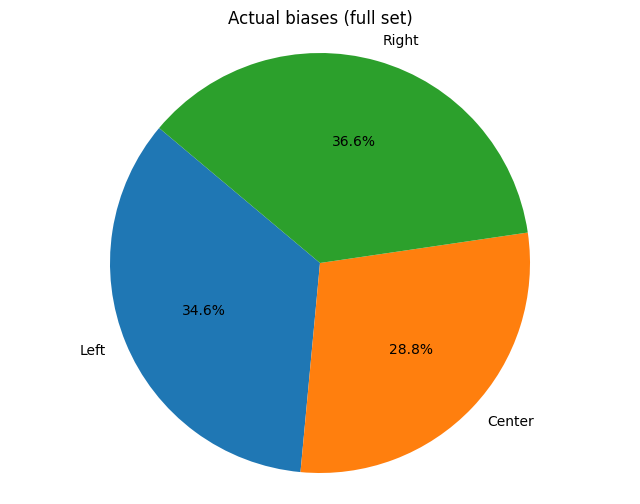

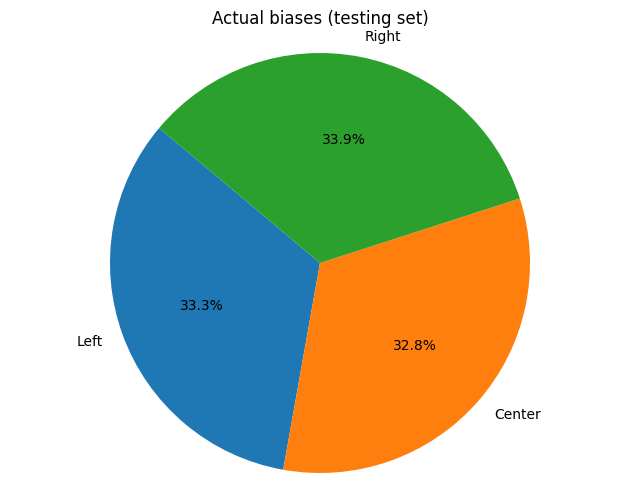

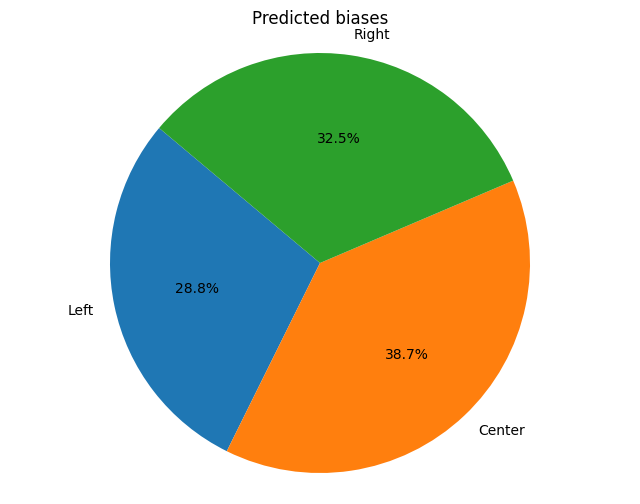

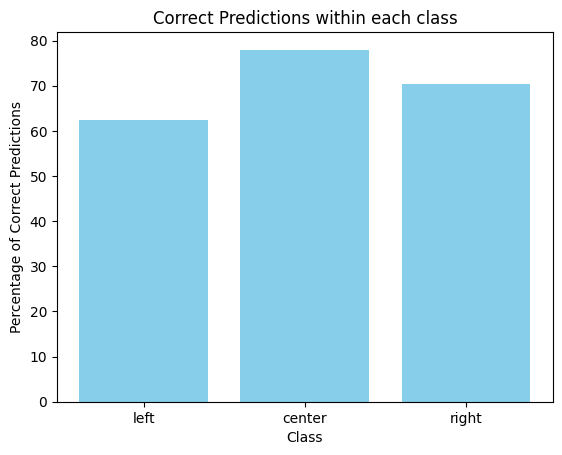

In [ ]:
import matplotlib.pyplot as plt

def plot_pie_chart(data, title):
    labels = ['Left', 'Center', 'Right']
    counts = [data.count(0), data.count(1), data.count(2)]
    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def plot_correct_predictions(correct_predictions, model_predictions):
    correct_counts = [0, 0, 0]
    counts = [correct_predictions.count(0), correct_predictions.count(1), correct_predictions.count(2)]
    
    for i in range(len(correct_predictions)):
        if correct_predictions[i] == model_predictions[i]:
            correct_counts[correct_predictions[i]] += 1

    correct_pcts = [correct_counts[0] / counts[0] * 100, correct_counts[1] / counts[1] * 100, correct_counts[2] / counts[2] * 100]
    
    labels = ['left', 'center', 'right']
    plt.bar(labels, correct_pcts, color='skyblue')
    plt.title('Correct Predictions within each class')
    plt.xlabel('Class')
    plt.ylabel('Percentage of Correct Predictions')
    plt.show()

left_correct = 0
center_correct = 0
right_correct = 0
for i in range(len(y_test_list)):
    if y_test_list[i] == y_pred_list[i]:

        if y_test_list[i] == 0:
            left_correct += 1

        if y_test_list[i] == 1:
            center_correct += 1

        if y_test_list[i] == 2:
            right_correct += 1

print(left_correct, center_correct, right_correct)

plot_pie_chart(list(bias), 'Actual biases (full set)')
plot_pie_chart(y_test_list, 'Actual biases (testing set)')
plot_pie_chart(y_pred_list, 'Predicted biases')

plot_correct_predictions(y_test_list, y_pred_list)

Index(['elections', 'politics', 'white_house', 'immigration'], dtype='object')


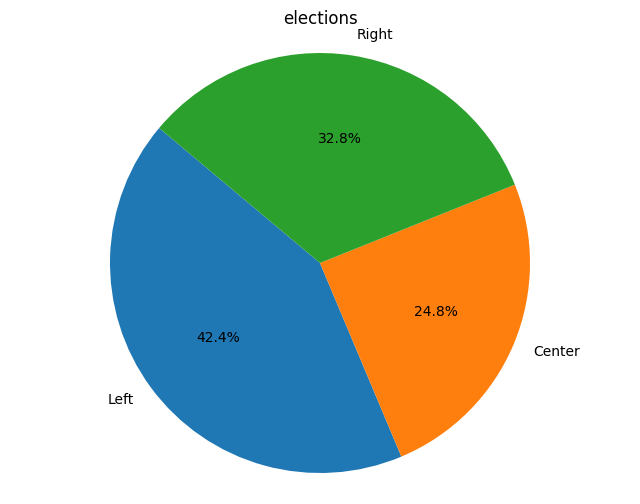

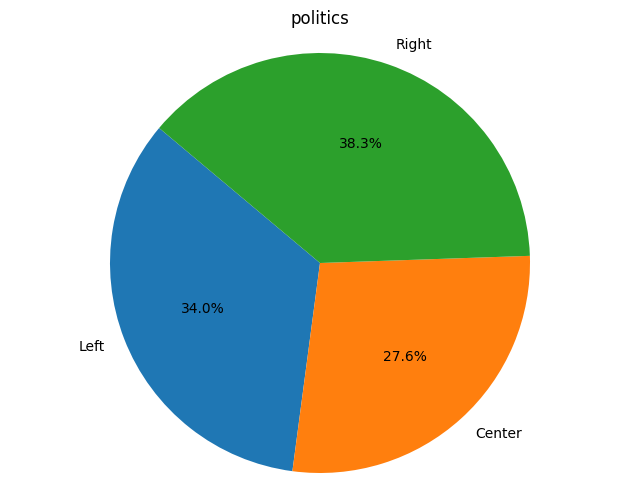

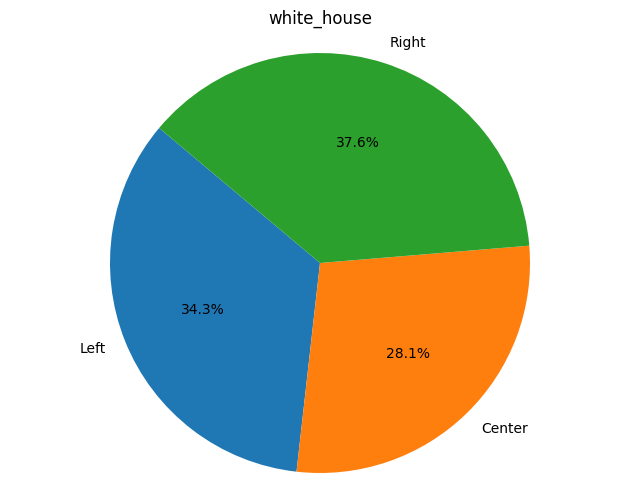

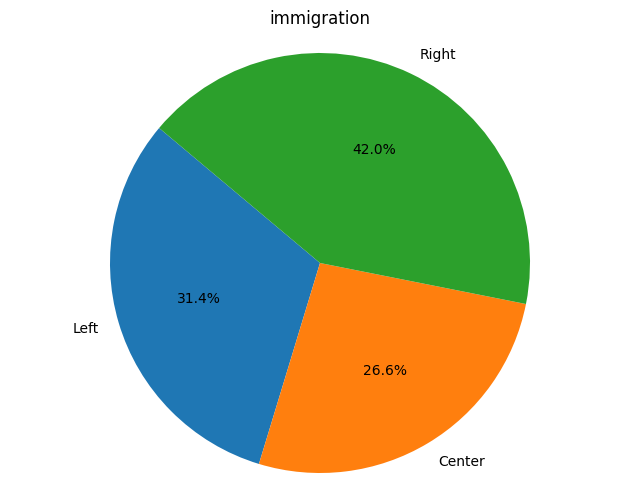

In [ ]:
#create pie charts for the biases within the top 4 topics
topic_counted = pd.Series(topics).value_counts()
top_topics = topic_counted.index[:4]
print(top_topics)
for topic in top_topics:
    topic_mask = np.array(topics) == topic
    topic_bias = np.array(bias)[topic_mask]
    plot_pie_chart(list(topic_bias), topic)